In [1]:
import numpy as np
import pandas as pd

import re
import string
import nltk
from nltk.corpus import stopwords
import texthero as hero
from wordcloud import WordCloud

import torch
torch.manual_seed(10)
from torch.autograd import Variable
from torch.utils.data import DataLoader

import lightgbm as lgb
from lightgbm import LGBMClassifier

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold, RandomizedSearchCV

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
sns.set()

import os

import warnings
warnings.filterwarnings("ignore")

INPUT = "./data/"
OUTPUT = "./output"

In [2]:
corpus = [
    'drink milk',
    'drink cold water',
    'drink cold cola',
    'drink juice',
    'drink cola',
    'eat bacon',
    'eat mango',
    'eat cherry',
    'eat apple',
    'juice with sugar',
    'cola with sugar',
    'mango is fruit',
    'apple is fruit',
    'cherry is fruit',
    'Berlin is Germany',
    'Boston is USA',
    'Mercedes from Germany',
    'Mercedes is a car',
    'Ford from USA',
    'Ford is a car'
]

In [3]:
def create_vocablary(corpus):
    '''create a dictionary with all unique words in corpus with id'''
    vocabulary = {}
    i = 0
    for s in corpus:
        for w in s.split():
            if w not in vocabulary:
                vocabulary[w] = i
                i += 1
    return vocabulary

def prepare_set(corpus, n_gram):
    '''create a dataset with input column and outputs column for neighboring words
       
       The number of neighbors = n_gram*2
    '''
    
    columns = ["Input"] + [f'Output{i+1}' for i in range(n_gram*2)]
    result = pd.DataFrame(columns=columns)
    for sentence in corpus:
        for i, w in enumerate(sentence.split()):
            inp = [w]
            out = []
            for n in range(1, n_gram+1):
                if (i - n) >= 0:
                    out.append(sentence.split()[i - n])
                else:
                    out.append("<padding>")
                    
                if (i+n)<len(sentence.split()):
                    out.append(sentence.split()[i+n])
                else:
                    out.append("<padding>")
                
            row = pd.DataFrame([inp+out], columns = columns)
            result = result.append(row, ignore_index=True)
    return result

In [4]:
def prepare_set_ravel(corpus, n_gram = 1):
    '''Creates a dataset with Input column and Output column for neighboring words. 
       The number of neighbors = n_gram*2'''
    columns = ['Input', 'Output']
    result = pd.DataFrame(columns = columns)
    for sentence in corpus:
        for i,w in enumerate(sentence.split()):
            inp = w
            for n in range(1,n_gram+1):
                # look back
                if (i-n)>=0:
                    out = sentence.split()[i-n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = result.append(row, ignore_index = True)
                
                # look forward
                if (i+n)<len(sentence.split()):
                    out = sentence.split()[i+n]
                    row = pd.DataFrame([[inp,out]], columns = columns)
                    result = result.append(row, ignore_index = True)
    return result

In [5]:
stop_words = set(stopwords.words("english"))

def preprocess(corpus):
    result = []
    for i in corpus:
        out = nltk.word_tokenize(i)
        out = [x.lower() for x in out]
        out = [x for x in out if x not in stop_words]
        result.append(" ".join(out))
    return result

corpus = preprocess(corpus)
corpus

['drink milk',
 'drink cold water',
 'drink cold cola',
 'drink juice',
 'drink cola',
 'eat bacon',
 'eat mango',
 'eat cherry',
 'eat apple',
 'juice sugar',
 'cola sugar',
 'mango fruit',
 'apple fruit',
 'cherry fruit',
 'berlin germany',
 'boston usa',
 'mercedes germany',
 'mercedes car',
 'ford usa',
 'ford car']

In [6]:
vocabulary = create_vocablary(corpus)
vocabulary

{'drink': 0,
 'milk': 1,
 'cold': 2,
 'water': 3,
 'cola': 4,
 'juice': 5,
 'eat': 6,
 'bacon': 7,
 'mango': 8,
 'cherry': 9,
 'apple': 10,
 'sugar': 11,
 'fruit': 12,
 'berlin': 13,
 'germany': 14,
 'boston': 15,
 'usa': 16,
 'mercedes': 17,
 'car': 18,
 'ford': 19}

In [7]:
train_emb = prepare_set(corpus, n_gram=2)
train_emb.head()

,Input,Output1,Output2,Output3,Output4
0,drink,<padding>,milk,<padding>,<padding>
1,milk,drink,<padding>,<padding>,<padding>
2,drink,<padding>,cold,<padding>,water
3,cold,drink,water,<padding>,<padding>
4,water,cold,<padding>,drink,<padding>


In [8]:
train_emb = prepare_set_ravel(corpus, n_gram=2)
train_emb.head(10)

,Input,Output
0,drink,milk
1,milk,drink
2,drink,cold
3,drink,water
4,cold,drink
5,cold,water
6,water,cold
7,water,drink
8,drink,cold
9,drink,cola


In [9]:
train_emb.Input = train_emb.Input.map(vocabulary)
train_emb.Output = train_emb.Output.map(vocabulary)
train_emb.head(10)

,Input,Output
0,0,1
1,1,0
2,0,2
3,0,3
4,2,0
5,2,3
6,3,2
7,3,0
8,0,2
9,0,4


In [10]:
vocab_size = len(vocabulary)

def get_input_tensor(tensor):
    '''Transform 1D tensor of word indexes to one-hot encooded 2D tensor'''
    size = [*tensor.shape][0]
    inp = torch.zeros(size, vocab_size).scatter_(1, tensor.unsqueeze(1), 1.)
    return Variable(inp).float()

In [11]:
embedding_dims = 5
device = torch.device('cpu')

In [12]:
initrange = 0.5 / embedding_dims
W1 = Variable(torch.rand(vocab_size, embedding_dims, device=device).uniform_(-initrange, initrange).float(), requires_grad=True)

W2 = Variable(torch.randn(embedding_dims, vocab_size, device=device).uniform_(-initrange, initrange).float(), requires_grad=True)
print(f" W1 shape is: {W1.shape}, W2 shape is: {W2.shape}")

 W1 shape is: torch.Size([20, 5]), W2 shape is: torch.Size([5, 20])


In [13]:
num_epochs = 2000
learning_rate = 2e-1
lr_decay = 0.99
loss_hist = []

In [14]:
%%time
for epo in range(num_epochs):
    for x,y in zip(DataLoader(train_emb.Input.values, batch_size=train_emb.shape[0]), DataLoader(train_emb.Output.values, batch_size=train_emb.shape[0])):
        
        # one-hot encode input tensor
        input_tensor = get_input_tensor(x) #shape N*V
     
        # simple NN architecture
        h = input_tensor.mm(W1) # shape 1*H
        y_pred = h.mm(W2) # shape 1*V
        
        # define loss func
        loss_f = torch.nn.CrossEntropyLoss() # see details: https://pytorch.org/docs/stable/nn.html
        
        #compute loss
        loss = loss_f(y_pred, y)
        
        # bakpropagation step
        loss.backward()
        
        # Update weights using gradient descent. For this step we just want to mutate
        # the values of w1 and w2 in-place; we don't want to build up a computational
        # graph for the update steps, so we use the torch.no_grad() context manager
        # to prevent PyTorch from building a computational graph for the updates
        with torch.no_grad():
            # SGD optimization is implemented in PyTorch, but it's very easy to implement manually providing better understanding of process
            W1 -= learning_rate*W1.grad.data
            W2 -= learning_rate*W2.grad.data
            # zero gradients for next step
            W1.grad.data.zero_()
            W1.grad.data.zero_()
    if epo%10 == 0:
        learning_rate *= lr_decay
    loss_hist.append(loss)
    if epo%50 == 0:
        print(f'Epoch {epo}, loss = {loss}')

Epoch 0, loss = 2.995542287826538
Epoch 50, loss = 2.5288288593292236
Epoch 100, loss = 1.263617753982544
Epoch 150, loss = 0.9527688026428223
Epoch 200, loss = 0.9078896641731262
Epoch 250, loss = 1.1908965110778809
Epoch 300, loss = 1.2190020084381104
Epoch 350, loss = 1.0700225830078125
Epoch 400, loss = 1.110177755355835
Epoch 450, loss = 1.119644045829773
Epoch 500, loss = 1.0889474153518677
Epoch 550, loss = 1.3177329301834106
Epoch 600, loss = 1.0046061277389526
Epoch 650, loss = 1.1412726640701294
Epoch 700, loss = 1.0983895063400269
Epoch 750, loss = 1.0857535600662231
Epoch 800, loss = 1.2452772855758667
Epoch 850, loss = 1.1283069849014282
Epoch 900, loss = 1.0852253437042236
Epoch 950, loss = 1.1333281993865967
Epoch 1000, loss = 1.0684341192245483
Epoch 1050, loss = 1.0415608882904053
Epoch 1100, loss = 1.0232638120651245
Epoch 1150, loss = 1.0046851634979248
Epoch 1200, loss = 0.9911534190177917
Epoch 1250, loss = 0.9782195091247559
Epoch 1300, loss = 0.9648787379264832
E

In [15]:
W1 = W1.detach().numpy()
W2 = W2.T.detach().numpy()

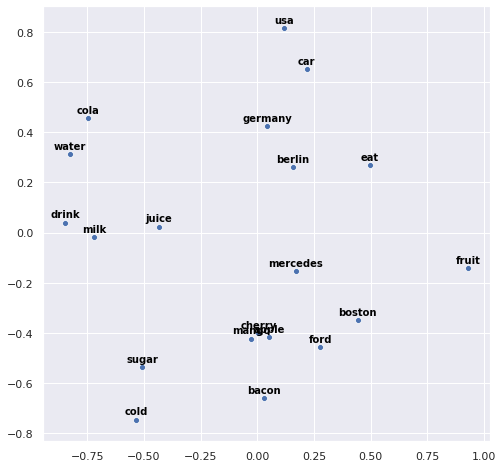

In [18]:
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=2)
W1_dec = svd.fit_transform(W1)
x = W1_dec[:,0]
y = W1_dec[:,1]
plt.figure(figsize=(8, 8))
plot = sns.scatterplot(x, y)

for i in range(0,W1_dec.shape[0]):
     plot.text(x[i], y[i]+2e-2, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');

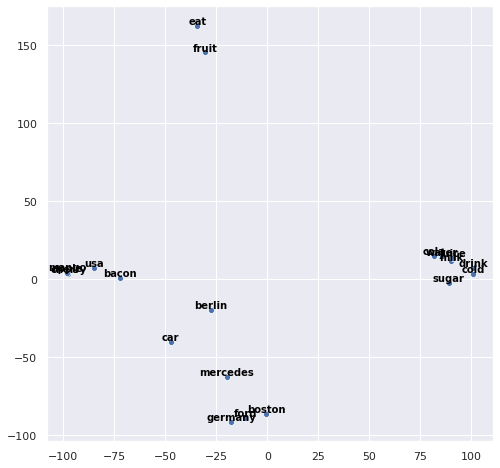

In [20]:
W2_dec = svd.fit_transform(W2)
x1 = W2_dec[:,0]
y1 = W2_dec[:,1]
plt.figure(figsize=(8, 8))
plot1 = sns.scatterplot(x1, y1)
for i in range(0,W2_dec.shape[0]):
     plot1.text(x1[i], y1[i]+1, list(vocabulary.keys())[i], horizontalalignment='center', size='small', color='black', weight='semibold');